In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tasks, imports and parameters



In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install syntok
!pip install matplotlib

     |████████████████████████████████| 2.3MB 3.8MB/s 
     |████████████████████████████████| 901kB 16.8MB/s 
     |████████████████████████████████| 3.3MB 21.6MB/s 
     |████████████████████████████████| 81kB 2.7MB/s 
     |████████████████████████████████| 1.2MB 14.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=2d26f5331446c2876f6100725313f5873938d32a80279e613ebffb6e58888e11
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers
  Created wheel for syntok: filename=syntok-1.3.1-cp37-none-any.whl size=20919 sha256=7dcdb5c256fe3c9524f0a627890f1f236534adb52d46bd1ebdf3516c7279c3ae
  Stored in directory: /root/.cache/pip/wheels/51/c6/a4/be1920586c49469846bcd2888200bdecfe109ec421dab9be2d
Successfully built syntok


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from syntok.tokenizer import Tokenizer
import regex as re
from nltk.corpus import stopwords
import nltk
import math
import pickle
import numpy
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt 
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from nltk.util import ngrams
import collections
import subprocess
import sys
import glob
import os
import copy

nltk.download('stopwords')

SEGMENTS_SIZE = 100 # size in characters (without cleaning)
COUNT_NUMBER = 5 # the number of segments taking care of
TH_COSIN_VALUE = 0.75
SECTION_POSITION_MAX_DIF = 100
REQUIRED_GRAMS = 2

ENCOPLOT_MAX_STEP_DIF = 10
ENCOPLOT_MIN_FOUND_CONSECUTIVE = 30

MODEL_NAME = 'xlm-r-distilroberta-base-paraphrase-v1'
# MODEL_NAME = 'nli-mpnet-base-v2'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#@title
%%writefile encoplot.cpp

//computes the encoplot data of a pair
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/types.h>
#include <sys/stat.h>
#include <unistd.h>
#include <regex>
#include <string>
#include <iostream>

typedef __int128 tngram;
//CrGrsort
#define fr(x,y) for(int x=0; x<y; x++)

int* index_rsort_ngrams(unsigned char *x,int l,int DEPTH) {
    int NN = l - DEPTH + 1; 
    if(NN>0) {
        unsigned char *pin = x + NN;
        unsigned char *pout = x;
        int *ix = (int*) malloc(NN * sizeof(int));
        int *ox = (int*) malloc(NN * sizeof(int));
        const int RANGE = 256;
        int counters[RANGE]; 
        int startpos[RANGE];

        fr(i,NN) ix[i] = i;
        //radix sort,the input is x,
        //the output rank is ix
        fr(k,RANGE) counters[k] = 0;
        fr(i,NN) counters[*(x+i)]++;
        fr(j,DEPTH) {
            int ofs = j;//low endian
            int sp = 0;
        
            fr(k,RANGE) {
                startpos[k] = sp;
                sp += counters[k];
            }

            fr(i,NN) {
                unsigned char c = x[ofs+ix[i]];
                ox[startpos[c]++] = ix[i];
            }

            memcpy(ix, ox, NN * sizeof(ix[0]));
            
            //update counters
            if(j < DEPTH - 1) {
                counters[*pout++]--;
                counters[*pin++]++;
            }
        }

        free(ox);
            
        return ix;
    }
}

#define MAXBUFSIZ 8000123
unsigned char file1[MAXBUFSIZ];
unsigned char file2[MAXBUFSIZ];
int l1,l2;

inline tngram readat(const unsigned char *buf, int poz){
    return *(tngram*)(buf + poz);
}

int main(int argc,char** argv) {
    int depth = sizeof(tngram);
    FILE* f1 = fopen(argv[1],"rb");

    l1 = fread(file1, 1, MAXBUFSIZ, f1);
    fclose(f1);
    FILE* f2=fopen(argv[2], "rb");
    l2 = fread(file2, 1, MAXBUFSIZ, f2);
    fclose(f2);
    //index the ngrams
    int *ix1 = index_rsort_ngrams(file1, l1, depth);
    int *ix2 = index_rsort_ngrams(file2, l2, depth);
    int i1 = 0;
    int i2 = 0;//merge
    tngram s1 = readat(file1, ix1[i1]);
    tngram s2 = readat(file2, ix2[i2]);
    l1 -= (depth - 1);
    l2 -= (depth - 1);
    while(i1 < l1 && i2 < l2) {
        if(s1 == s2) {
            printf("%d-%d,", ix1[i1], ix2[i2]);
        i1++;
        if(i1 < l1) s1 = readat(file1,ix1[i1]);

        i2++;
        if(i2 < l2)
            s2 = readat(file2,ix2[i2]);
        }
        else if(s1 < s2) {
            i1++;
            if(i1 < l1)
                s1 = readat(file1, ix1[i1]);
        }
        else if(s2 < s1) {
            i2++;
            if(i2 < l2)
                s2 = readat(file2,ix2[i2]);
        }
    }
    
    free(ix2);
    free(ix1);
    return 0;
}

Writing encoplot.cpp


In [ ]:
%%shell

g++ encoplot.cpp

# Segment class for generic segments

Members:
  - text
  - offset
  - cleaned_text
  - length (optional, default to 0)

In [ ]:
class Segment():
  def __init__(self, text, offset, cleaned_text, length = 0):
    self.text = text
    self.offset = offset
    self.cleaned_text = cleaned_text
    self.length = length

    if length == 0:
      self.length = len(text)
    else:
      self.length = length

  def __str__(self):
    result = "offset: " + str(self.offset) + " length: " + str(self.length)
    return result

  def __repr__(self):
    result = "offset: " + str(self.offset) + " length: " + str(self.length)
    return result

  # equal is it has same offset or length or is overlaped or is at less than SECTION_POSITION_MAX_DIF distance
  def __eq__(self, other): 
    s_start = self.offset
    s_end = self.offset + self.length
    o_start = other.offset
    o_end = other.offset + other.length

    if s_start >= o_start:
      if s_end <= o_end:
        return True
      elif o_end >= s_start:
        return True
      else:
        if s_start > o_end and s_start - o_end < SECTION_POSITION_MAX_DIF:
          return True
        else:
          return False
    else:
      if o_end <= s_end:
        return True
      elif s_end >= o_start:
        return True
      else:
        if o_start > s_end and o_start - s_end < SECTION_POSITION_MAX_DIF:
          return True
        else:
          return False

    return False

# Plagiarism Class - for document known plagiarism list - used for later evaluation

Members:
  - this_offset
  - this_length
  - source_offset
  - source_length

In [ ]:
class Plagiarism():
  def __init__(self, this_offset, this_length, source_reference, source_offset, source_length):
    self.this_offset = this_offset 
    self.this_length = this_length 
    self.source_reference = source_reference
    self.source_offset = source_offset
    self.source_length = source_length

# FeatureList class - used for document known features

Members:
  - plagiarism_list

In [ ]:
class FeaturesList():
  def __init__(self, path):
    self.plagiarism_list = []

    document = ET.parse(path)
    root = document.getroot()

    for child in root:

      # Check language
      if child.attrib['name'] == "language":
        lan = child.attrib['value']

        if lan == "en":
          self.language = "english"
        elif lan == "de":
          self.language = "german"
        elif lan == "es":
          self.language = "spanish"
        else:
          self.language = "english"

      # check plagiarism list (if it is the case)
      if child.attrib['name'] == "artificial-plagiarism":
        this_offset = child.attrib['this_offset']
        this_length = child.attrib['this_length']
        source_reference = child.attrib['source_reference']
        source_offset = child.attrib['source_offset']
        source_length = child.attrib['source_length']
        
        self.plagiarism_list.append(Plagiarism(this_offset, this_length, source_reference, source_offset, source_length))

# Document class - containing document features, segments, and embeddings

Members:
  - text
  - features
  - doc_name
  - segments
  - embeddings

In [ ]:
class Document():
  def __init__(self, path, doc_name):
    file = open(path + doc_name + ".txt", "r")
    self.text = file.read() 
    file.close()

    self.features = FeaturesList(path + doc_name + ".xml")
    self.doc_name = doc_name + ".txt"
    self.segments = []

    self.embeddings = None

  def split_segments(self, size, min_windows_distance, offset_list):
    tok = Tokenizer()
    word_list = []
    self.segments = []

    segment_list = []

    last_offset = (-1) * size

    # extract the raw segments
    for offset in offset_list:
      if (offset - last_offset) > min_windows_distance:
        candidate_start_offset = offset
        candidate_end_offset = offset + size

        try:
          before = candidate_start_offset
          while candidate_start_offset > 0 and self.text[candidate_start_offset - 1] != " ":
            candidate_start_offset -= 1

          while candidate_end_offset < len(self.text) and self.text[candidate_end_offset] != " ":
            candidate_end_offset += 1
          
          segment_list.append([self.text[candidate_start_offset: candidate_end_offset], candidate_start_offset])
        except:
          # invalid encoplot offset
          pass


      last_offset = offset

    # clean the raw text segments
    stop_words = stopwords.words(self.features.language)
    cleaned_segments = []

    for seg in segment_list:
      seg_splits = (re.sub('[^a-zA-Z]', ' ', seg[0])).lower()
      seg_splits = seg_splits.split()
      cleaned_seg = ""
      for current_seg in seg_splits:
        if current_seg not in stop_words:
          cleaned_seg += " " + current_seg
      
      cleaned_segments.append(cleaned_seg)
    
    for raw_s, cleaned_s in zip(segment_list, cleaned_segments):
      self.segments.append(Segment(raw_s[0], raw_s[1], cleaned_s))
    
  def compute_embeddings(self, model_name):
    prep_text = []
    
    for it in self.segments:
      # print(it)
      prep_text.append(it.cleaned_text)

    # print(prep_text)
    model = SentenceTransformer(model_name)
    self.embeddings = model.encode(prep_text)

# PredictedSegment class - used to store the most similar segment pairs by cosine similarity

Members:
  - this_segment
  - source_reference
  - source_segment
  - similarity_value

In [ ]:
class PredictedSegment():
  def __init__(self, this_segment, source_reference, source_segment, similarity_value):
    self.this_segment = this_segment
    self.source_reference = source_reference
    self.source_segment = source_segment
    self.similarity_value = similarity_value

  def __str__(self):
    result = "source_ref: " + self.source_reference + " this_segment: " + str(self.this_segment) + " source_segment: " + str(self.source_segment) +  " similarity_value: " + str(self.similarity_value) 
    return result

  def __repr__(self):
    result = "source_ref: " + self.source_reference + "this_segment: " + str(self.this_segment) + " source_segment: " + str(self.source_segment) +  " similarity_value: " + str(self.similarity_value) 
    return result

  def __eq__(self, other): 
    if self.this_segment == other.this_segment and self.source_segment == other.source_segment:
      return True
    else:
      return False

  def check_same_plagiarism_segment(self, other):
    if self.this_segment == other.this_segment:
      return True
    else:
      return False

# get_most_similars(...) and plot_similar_segments(...) - used to get the most similar segments pairs (due to cosine similarity)

- get_most_similars(source_doc, suspicious_doc)
- plot_similar_segments(pred_segments)

In [ ]:
def get_most_similars(source_doc, suspicious_doc):
  segments = []
  similarity_matrix = cosine_similarity(source_doc.embeddings, suspicious_doc.embeddings)

  for it in range(len(similarity_matrix[0])):
    current_row = similarity_matrix[:, it]

    # sort the indexes by the cosine similarity of the embeddings
    similar_ix = np.argsort(current_row)[::-1]

    # save the first N similar segments by the cosine value
    for i in range(COUNT_NUMBER): 
      try:
        segments.append(PredictedSegment(suspicious_doc.segments[it], source_doc.doc_name, source_doc.segments[similar_ix[i]], current_row[similar_ix[i]]))
      except:
        # not enough segments
        pass

  return segments

def plot_similar_segments(pred_segments):
  offset_list = []
  cosine_similarity_list = []

  for i in pred_segments:
    offset_list.append(i.this_segment.offset)
    cosine_similarity_list.append(i.similarity_value)

  plt.scatter(offset_list, cosine_similarity_list, alpha=.8, color="r")
  plt.show()

def plot_similar_segments_3d(pred_segments):
  offset_list = []
  s_offset_list = []
  cosine_similarity_list = []

  for i in pred_segments:
    offset_list.append(i.this_segment.offset)
    cosine_similarity_list.append(i.similarity_value)
    s_offset_list.append(i.source_segment.offset)

  # plt.scatter(offset_list, cosine_similarity_list, alpha=.8, color="r")
  # plt.show()
  ax = plt.axes(projection='3d')
  ax.scatter(offset_list, s_offset_list, cosine_similarity_list, c=cosine_similarity_list, cmap='viridis', linewidth=0.5);
  plt.show()

def plot_similar_segments_3d_by_cluster(pred_segments, clusters):
  offset_list = []
  s_offset_list = []
  cosine_similarity_list = []

  for i in pred_segments:
    offset_list.append(i.this_segment.offset)
    cosine_similarity_list.append(i.similarity_value)
    s_offset_list.append(i.source_segment.offset)

  # plt.scatter(offset_list, cosine_similarity_list, alpha=.8, color="r")
  
  ax = plt.axes(projection='3d')
  ax.scatter(offset_list, s_offset_list, cosine_similarity_list, marker="s", c=clusters, cmap='Dark2', linewidth=0.5);
  plt.show()

# predictions class


In [ ]:
class Predictions():
  # plagiarism_predicted = []
  # predicted_segments = []
  # _extracted_predicted_segments = []
  # doc_name = ""

  def __init__(self):
    self.plagiarism_predicted = []
    self.predicted_segement = []
    self.current_suspicious_doc = ""
    self._extracted_predicted_segments = []
    self.results = {}

  def add_prediction(self, predicted_segments, suspicious_doc):
    self.predicted_segments = predicted_segments
    self.current_suspicious_doc = suspicious_doc

    if len(self.predicted_segments) > 0:
      self._compute_predictions()
      self._extracted_predicted_segments = []

    if self.current_suspicious_doc not in self.results:
      self.results[self.current_suspicious_doc] = []

    for prediction in self.plagiarism_predicted:
      conflicts = False

      # if prediction.this_segment.length < 
      
      for result in self.results[suspicious_doc]:
        if prediction.check_same_plagiarism_segment(result):
          conflicts = True
          break

      if not conflicts: # and prediction.similarity_value > TH_COSIN_VALUE:
        # print(prediction)
        self.results[self.current_suspicious_doc].append(prediction)

    self.plagiarism_predicted = []

    return self.results[self.current_suspicious_doc]


  def _compute_predictions(self):
    self._extracted_predicted_segments = self._extract()

    if len(self._extracted_predicted_segments) == 0:
      return
      
    # plot_similar_segments_3d(self._extracted_predicted_segments)
    X, labels = self._make_clusters()

    # print all the extracted predicted segments of that label 

    # print(max(labels) + 1)
    # print(type(self._extracted_predicted_segments[0]))
    
    # combine the clusters
    first_seg = []
    result_seg = []
    similarity_value_count = []
    objects_passed = []

    for it in range(max(labels) + 1):
      first_seg.append(False)
      result_seg.append(None)
      similarity_value_count.append(0)
      objects_passed.append(0)
  
    for seg, label in zip(self._extracted_predicted_segments, labels):
      if label != -1:
        if first_seg[label] == False:
          first_seg[label] = True
          result_seg[label] = seg
          similarity_value_count[label] = seg.similarity_value
          objects_passed[label] += 1
        else:
          result_seg[label] = self._merge_segments(result_seg[label], seg)
          similarity_value_count[label] += seg.similarity_value
          objects_passed[label] += 1

    for it in result_seg:
      it.similarity_value = similarity_value_count[label] / objects_passed[label]

    # # check singular detections
    # for seg, label in zip(self._extracted_predicted_segments, labels):
    #   if label == -1:
    #     grams_counter = 0
        
    #     try:
    #       tokenized_this = seg.this_segment.cleaned_text.split() 
    #       tokenized_source = seg.source_segment.cleaned_text.split() 
          
    #       # print(seg.this_segment.cleaned_text)
    #       bigram_this = ngrams(tokenized_this, 2)

    #       # for gram in bigram_this:
    #       #   print(gram)

    #       # print("\n" + seg.source_segment.cleaned_text)
    #       bigram_source = ngrams(tokenized_source, 2)

    #       # for gram in bigram_source:
    #       #   print(gram)

    #       for gram_this in ngrams(tokenized_this, 2):
    #         for gram_source in ngrams(tokenized_source, 2):
    #           if gram_this == gram_source:
    #             grams_counter += 1

    #       # print("\nGrams found: ", grams_counter)

    #       overlap = False
    #       if grams_counter >= REQUIRED_GRAMS: 
    #         for it in result_seg:
    #           if it.this_segment == seg.this_segment or it.source_segment == seg.source_segment:
    #             overlap = True
    #             break

    #         if overlap == False:
    #           result_seg.append(seg)
    #     except:
    #       print("except for " + seg.this_segment.cleaned_text)
    #       print(seg.this_segment)

    #       print("and " + seg.source_segment.cleaned_text)
    #       print(seg.source_segment)

        # print(seg.source_segment.text)


    # for it in result_seg:
    #   print(it)

    self.plagiarism_predicted = result_seg


  def _extract(self):
    th_segs = []

    for seg in self.predicted_segments:
      if seg.similarity_value > TH_COSIN_VALUE:
        th_segs.append(seg)

    loop = True

    while loop:
      loop = False
      for seg in self.predicted_segments:
        for th_s in th_segs:
          if seg == th_s and seg not in th_segs:
            th_segs.append(seg)
            loop = True


    th_segs.sort(key = lambda x: x.this_segment.offset)
      

    return th_segs

  def _make_clusters(self):
    features = []

    for it in self._extracted_predicted_segments:
      features.append([it.this_segment.offset, it.source_segment.offset, it.similarity_value]) # without ", it.similarity_value"

    X = numpy.array(features)
    # X = preprocessing.normalize(X) # - Normalized is ok for this example, but not so good for smaller documents
    # X = X[X[:, 0].argsort()]

    clustering_model = DBSCAN(eps=SECTION_POSITION_MAX_DIF * SECTION_POSITION_MAX_DIF / 1.5, min_samples=3) # SECTION_POSITION_MAX_DIF * SECTION_POSITION_MAX_DIF / 2 or eps = 0.03 for normalised
    clusters = clustering_model.fit(X[:, 0:2])

    # print(clusters.labels_)

    # uncomment in order to plot
    # plt.scatter(X[:, 0], X[:, 1], marker="s", c=clusters.labels_, cmap='Dark2', linewidth=0.5);
    # plt.show()

    # plot_similar_segments_3d_by_cluster(self._extracted_predicted_segments, clusters.labels_)

    return X, clusters.labels_

  def _merge_segments(self, seg1: PredictedSegment, seg2: PredictedSegment) -> PredictedSegment:
    this_segment = Segment("", 0, "", 0)
    source_segment = Segment("", 0, "", 0)

    # merge this_segment
    if seg1.this_segment.offset < seg2.this_segment.offset:
      this_segment.offset = seg1.this_segment.offset
    else:
      this_segment.offset = seg2.this_segment.offset

    if (seg1.this_segment.offset + seg1.this_segment.length) > (seg2.this_segment.offset + seg2.this_segment.length):
      this_segment.length = seg1.this_segment.offset + seg1.this_segment.length - this_segment.offset
    else:
      this_segment.length = seg2.this_segment.offset + seg2.this_segment.length - this_segment.offset

    # merge source_segment
    if seg1.source_segment.offset < seg2.source_segment.offset:
      source_segment.offset = seg1.source_segment.offset
    else:
      source_segment.offset = seg2.source_segment.offset

    if (seg1.source_segment.offset + seg1.source_segment.length) > (seg2.source_segment.offset + seg2.source_segment.length):
      source_segment.length = seg1.source_segment.offset + seg1.source_segment.length - source_segment.offset
    else:
      source_segment.length = seg2.source_segment.offset + seg2.source_segment.length - source_segment.offset
        
    # merge the text

    this_segment.text = seg1.this_segment.text + ' ' + seg2.this_segment.text
    source_segment.text = seg1.source_segment.text + ' ' + seg2.source_segment.text
    
    this_segment.cleaned_text = seg1.this_segment.cleaned_text + ' ' + seg2.this_segment.cleaned_text
    source_segment.cleaned_text = seg1.source_segment.cleaned_text + ' ' + seg2.source_segment.cleaned_text

    return PredictedSegment(this_segment, seg1.source_reference, source_segment, (seg1.similarity_value + seg2.similarity_value) / 2)

  def __add__(self, other_pred):
    add_result = copy.deepcopy(self)

    for doc_name in other_pred.results:
      add_result.current_suspicious_doc = doc_name   

      if doc_name not in add_result.results:
        add_result.results[add_result.current_suspicious_doc] = []

      for prediction in other_pred.results[doc_name]:
        conflicts = False
        
        for result in add_result.results[doc_name]:
          if prediction.check_same_plagiarism_segment(result):
            conflicts = True
            break

        if not conflicts: # and prediction.similarity_value > TH_COSIN_VALUE:
          add_result.results[add_result.current_suspicious_doc].append(prediction)

    return add_result

# Validation metrics

In [ ]:
class ValidationMetrics:
  def __init__(self):
    self.true_positive = 0
    self.false_positive = 0
    self.false_negative = 0

    self.true_positive_list = [] # the segment
    self.false_positive_list = [] # the segment
    self.false_negative_list = [] # just the length

    self.feature_checklist = [] # in order to find the false positive

    self.recall = 0
    self.precision = 0
    self.n_features = 0
    self.n_prec = 0
    self.gran = 0

    self.prev_doc = ""

  def is_overlaping(self, actual_start, actual_end, pred_start, pred_end):
    if actual_start <= pred_end and actual_start >= pred_start or \
        actual_end <= pred_end and actual_end >= pred_start or \
        pred_end <= actual_end and pred_end >= actual_start or \
        pred_start <= actual_end and pred_start >= actual_start:
      return True
    else:
      return False

  def get_recall(self, actual_start, actual_length, source_name, predictions):
    covered = 0
    overlaped = 0

    actual_start = int(actual_start)
    actual_length = int(actual_length)
    actual_end = int(actual_start + actual_length)

    for pred in predictions:
      pred_start = int(pred.this_segment.offset)
      pred_length = int(pred.this_segment.length)
      pred_end = int(pred_start + pred_length)
      
      if self.is_overlaping(actual_start, actual_end, pred_start, pred_end) and \
          pred.source_reference == source_name:

        if actual_start >= pred_start:
          if actual_end >= pred_end:
            covered += pred_length - (actual_start - pred_start)
          else:
            covered += actual_length
        else:
          if actual_end >= pred_end:
            covered += pred_length
          else:
            covered += pred_length - (pred_end - actual_end)
    
    # Check the false negative 
    if covered == 0:
      self.false_negative += 1
      self.false_negative_list.append(actual_length)

    return covered / actual_length

  def get_precision(self, pred_start, pred_length, source_name, features_list):
    covered = 0
    overlaped = 0

    pred_start = int(pred_start)
    pred_length = int(pred_length)
    pred_end = int(pred_start + pred_length)

    positive_found = False

    for feature in features_list:  
      actual_start = int(feature.this_offset)
      actual_length = int(feature.this_length)
      actual_end = int(actual_start + actual_length)
      
      if self.is_overlaping(actual_start, actual_end, pred_start, pred_end) and \
          feature.source_reference == source_name:

        self.true_positive += 1
        positive_found = True # true positive counter  

        if actual_start >= pred_start:
          if actual_end >= pred_end:
            covered += pred_length - (actual_start - pred_start)
          else:
            covered += actual_length
        else:
          if actual_end >= pred_end:
            covered += pred_length
          else:
            covered += pred_length - (pred_end - actual_end)

    if not positive_found:
      self.false_positive += 1
      
    return covered / pred_length

  def get_granularity(self, actual_start, actual_length, source_name, predictions):
    covered = 0
    overlaped = 0

    actual_start = int(actual_start)
    actual_length = int(actual_length)
    actual_end = int(actual_start + actual_length)      

    for pred in predictions:
      pred_start = int(pred.this_segment.offset)
      pred_length = int(pred.this_segment.length)
      pred_end = int(pred_start + pred_length)
      
      if self.is_overlaping(actual_start, actual_end, pred_start, pred_end) and \
          pred.source_reference == source_name:
        covered += 1

    if covered == 0:
      return 1
    else:
      return covered

  def get_f1(self, precision, recall):
    try:
      return 2 * (precision * recall) / (precision + recall)
    except:
      return 0

  def add_to_evaluate(self, predictions_res, features_dict):
    for feature_key in features_dict: # features_key = the doc name
      for feature in features_dict[feature_key].plagiarism_list:
        if feature_key in predictions_res.results:
          self.recall += self.get_recall(feature.this_offset, feature.this_length, feature.source_reference, predictions_res.results[feature_key])
          self.gran += self.get_granularity(feature.this_offset, feature.this_length, feature.source_reference, predictions_res.results[feature_key])
        else:
          self.gran += 1
        
        self.n_features += 1

    for result_key in predictions_res.results: # result_key = the doc name
      for pred in predictions_res.results[result_key]:
        pred_prec = self.precision # for false/true positive
        self.precision += self.get_precision(pred.this_segment.offset, pred.this_segment.length, pred.source_reference, features_dict[result_key].plagiarism_list)
        self.n_prec += 1

        if pred_prec != self.precision:
          self.false_positive_list.append(pred)
        else:
          self.true_positive_list.append(pred)


  def get_overall_score(self):
    if self.n_prec == 0:
      if self.n_features == 0:
        print("No plagiarism")
        return "No plagiarism"

    if self.n_features != 0:
      self.recall /= self.n_features
      print("Recall: ", self.recall)

    if self.n_prec != 0:
      self.precision /= self.n_prec
      print("Precision: ", self.precision)

    if self.n_features != 0:
      self.gran /= self.n_features
      print("Granularity: ", self.gran)
    else:
      self.gran = 1

    if self.precision != 0 and self.recall != 0:
      f1 = self.get_f1(self.precision, self.recall)
    else:
      f1 = 0

    print("F1: ", f1)
    # for feature in doc.features.plagiarism_list:
      # actual_offset = feature.this_offset
      # actual_length = feature.this_offset
      # actual_end = actual_offset + actual_offset

    print("True positive: ", self.true_positive)
    print("False positive: ", self.false_positive)
    print("False negative: ", self.false_negative)

    return f1 / math.log(self.gran + 1, 2)

# Encoplot integration

In [ ]:
def get_docs(path):
  result = []
  result += glob.glob(path + "*.txt")

  if glob.glob(path + "*/"):
    for dir in glob.glob(path + "*/"):
      result += glob.glob(dir + "*.txt")
  
  return result

In [ ]:
class Encoplot:

  def __init__(self, suspicious_doc, source_doc):
    self.current_score = 0
    self.suspicious_posible_offsets = []
    self.source_posible_offsets = []

    # get the encoplot results
    encoplot_raw_result = str(subprocess.check_output(["./a.out", suspicious_doc, source_doc]))

    # process the results -> a list sorted by the suspicious offset
    encoplot_raw_result = encoplot_raw_result.replace(",'", "")
    encoplot_raw_result = encoplot_raw_result.replace("'", "")
    encoplot_raw_result = encoplot_raw_result.replace("b", "")

    if(len(encoplot_raw_result) == 0):
      return 
      
    encoplot_list = encoplot_raw_result.split(",")

    for it in range(0, len(encoplot_list)):
      encoplot_list[it] = encoplot_list[it].split("-")
      encoplot_list[it][0] = int(encoplot_list[it][0])
      encoplot_list[it][1] = int(encoplot_list[it][1])

    # sort the pairs
    sorting_key = lambda a : a[0]
    encoplot_list.sort(key=sorting_key)

    Succesfullsteps = 0
    lastStep = [0, 0]

    # check the "score" based on the consecutive pairs
    for it in encoplot_list:
      if abs(it[0] - lastStep[0] - it[1] + lastStep[1]) < ENCOPLOT_MAX_STEP_DIF:
        Succesfullsteps += 1
      else:
        Succesfullsteps = 0

      if Succesfullsteps == ENCOPLOT_MIN_FOUND_CONSECUTIVE:
        self.current_score += 1

      lastStep = it

    # it the score is better than 0, save the segments as well
    if self.current_score > 0:
      for it in encoplot_list:
        self.suspicious_posible_offsets.append(it[0])
        self.source_posible_offsets.append(it[1])

# current work

In [ ]:
def extract_path_and_doc_name(path):
  match = re.compile(r'(\w+.txt|\w+-\w+.txt)')
  
  match_result = match.findall(path)[0]
  path_result = path.replace(match_result, "")
  doc_result = match_result.replace(".txt", "")
  
  return [path_result, doc_result]

suspicious_doc_path, suspicious_doc_name = extract_path_and_doc_name("/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00001.txt")

In [ ]:
# 1 - many

def scan_for_plagiarism(suspicious_doc_full_path, source_document_full_path_list):
  suspicious_doc = None # the embedding will be computed only after encoplot
  
  pred_result = Predictions()

  suspicious_doc_path, suspicious_doc_name = extract_path_and_doc_name(suspicious_doc_full_path)
  encoplot_found = False

  for source_full_path in source_document_full_path_list:
    encoplot = Encoplot(suspicious_doc_full_path, source_full_path)

    if encoplot.current_score > 0:
      suspicious_doc = Document(suspicious_doc_path, suspicious_doc_name)
      suspicious_doc.split_segments(SEGMENTS_SIZE, SEGMENTS_SIZE / 4, encoplot.suspicious_posible_offsets)
      suspicious_doc.compute_embeddings(MODEL_NAME)

      source_doc_path, source_doc_name = extract_path_and_doc_name(source_full_path)

      source_doc = Document(source_doc_path, source_doc_name)
      source_doc.split_segments(SEGMENTS_SIZE, SEGMENTS_SIZE / 4,  encoplot.source_posible_offsets)
      source_doc.compute_embeddings(MODEL_NAME)

      similar_segments = get_most_similars(source_doc, suspicious_doc)
      # plot_similar_segments_3d(similar_segments)
      pred_result.add_prediction(similar_segments, suspicious_doc.doc_name)

  return pred_result

In [ ]:
PATH_SOURCE = "/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part"
PATH_SUSPICIOUS = "/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part"
SUSPICIOUS_DOCUMENT_PREFIX = "suspicious-document"
SOURCE_DOCUMENT_PREFIX = "source-document"

def check_part_folder(doc_name):
  doc_number = int(doc_name[-5 :])
  if doc_number % 2000 == 0:
    return doc_number // 2000
  else:
    return doc_number // 2000 + 1

def extract_sample(samples_sus_number):
  sources_list = []
  suspicious_list = []
  
  extracted_source_docs = []

  for i in range(1, samples_sus_number + 1):
    index = str(i)

    while len(index) < 5:
      index = '0' + index
      
    sus_doc_name =  SUSPICIOUS_DOCUMENT_PREFIX + index
    part_folder = str(check_part_folder(sus_doc_name))
    full_path = PATH_SUSPICIOUS + part_folder + "/" + sus_doc_name + ".txt"

    suspicious_list.append(full_path)

    fl = FeaturesList(full_path[:-4] + ".xml")

    for feature in fl.plagiarism_list:
      if feature.source_reference[: -4] not in extracted_source_docs:
        extracted_source_docs.append(feature.source_reference[: -4])

  for document in extracted_source_docs:
    part_folder = str(check_part_folder(document))
    sources_list.append(PATH_SOURCE + part_folder + '/' + document + ".txt")

  return suspicious_list, sources_list

In [ ]:
sus_sample, source_sample = extract_sample(5)

print("suspicios sample: " + str(len(sus_sample)))
print("sources sample: " + str(len(source_sample)))

suspicios sample: 5
sources sample: 8


LOADING


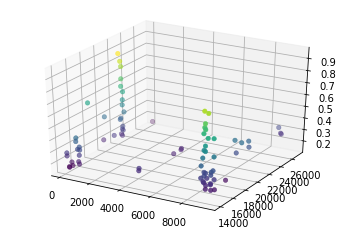

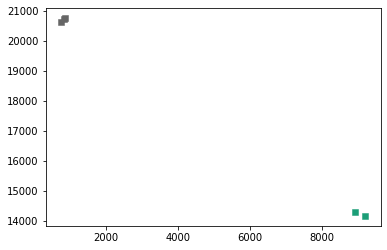

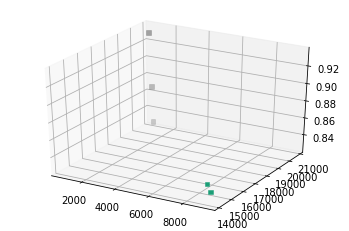

source_ref: source-document01409.txt this_segment: offset: 756 length: 220 source_segment: offset: 20640 length: 214 similarity_value: 0.8763201236724854
20.0%


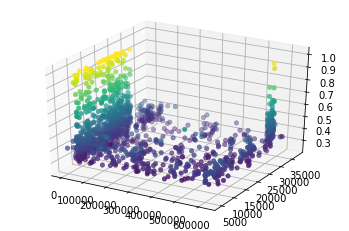

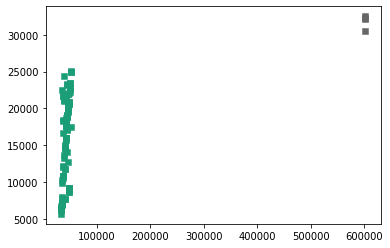

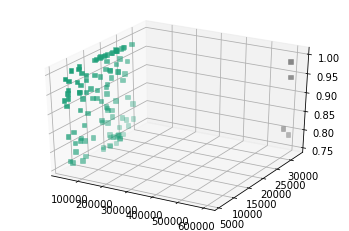

source_ref: source-document04063.txt this_segment: offset: 32471 length: 19018 source_segment: offset: 5706 length: 19452 similarity_value: 0.884789228439331
source_ref: source-document04063.txt this_segment: offset: 600506 length: 1414 source_segment: offset: 30566 length: 2041 similarity_value: 0.884789228439331


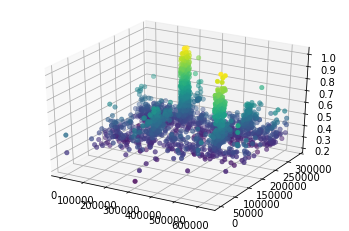

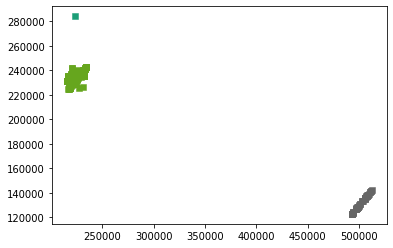

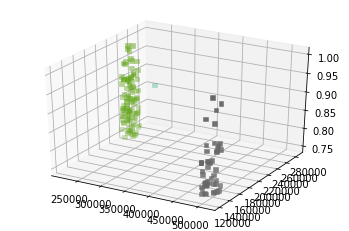

source_ref: source-document02400.txt this_segment: offset: 215971 length: 18494 source_segment: offset: 224618 length: 18542 similarity_value: 0.8240924591713763
source_ref: source-document02400.txt this_segment: offset: 492962 length: 19303 source_segment: offset: 122826 length: 19649 similarity_value: 0.8240924591713763
40.0%
60.0%


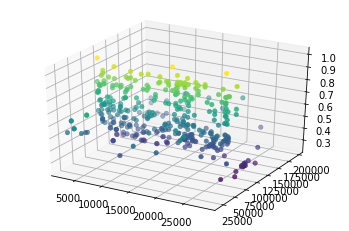

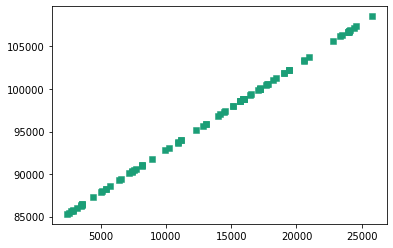

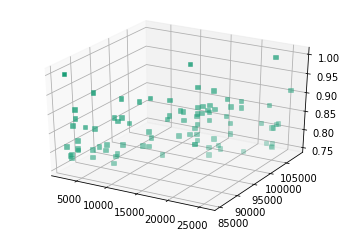

source_ref: source-document06728.txt this_segment: offset: 2442 length: 23408 source_segment: offset: 85321 length: 23334 similarity_value: 0.8422121946839081
80.0%


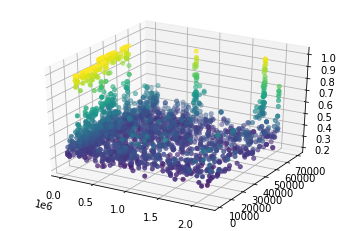

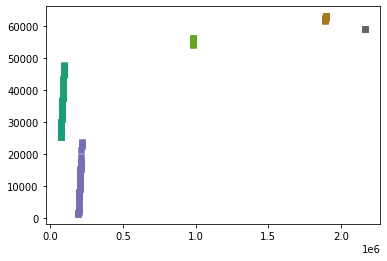

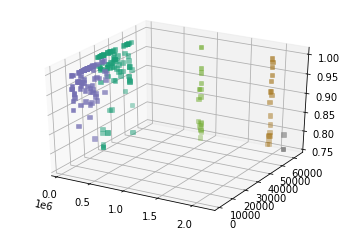

source_ref: source-document00548.txt this_segment: offset: 71192 length: 22857 source_segment: offset: 25082 length: 22830 similarity_value: 0.7769843737284342
source_ref: source-document00548.txt this_segment: offset: 192712 length: 22603 source_segment: offset: 1171 length: 22570 similarity_value: 0.7769843737284342
source_ref: source-document00548.txt this_segment: offset: 981108 length: 2376 source_segment: offset: 54043 length: 2298 similarity_value: 0.7769843737284342
source_ref: source-document00548.txt this_segment: offset: 1892373 length: 1641 source_segment: offset: 61353 length: 1736 similarity_value: 0.7769843737284342
source_ref: source-document00548.txt this_segment: offset: 2166347 length: 111 source_segment: offset: 58928 length: 152 similarity_value: 0.7769843737284342


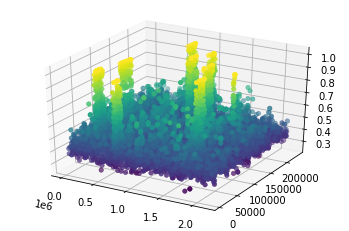

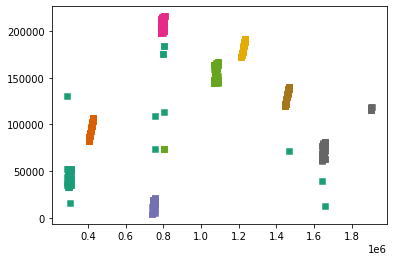

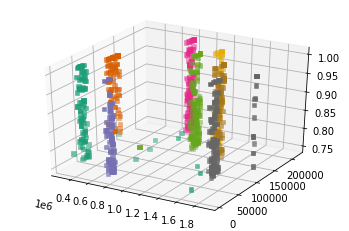

source_ref: source-document02225.txt this_segment: offset: 290189 length: 19768 source_segment: offset: 32697 length: 19925 similarity_value: 0.8844088912010193
source_ref: source-document02225.txt this_segment: offset: 403874 length: 24309 source_segment: offset: 82306 length: 24290 similarity_value: 0.8844088912010193
source_ref: source-document02225.txt this_segment: offset: 741362 length: 17064 source_segment: offset: 4116 length: 17120 similarity_value: 0.8844088912010193
source_ref: source-document02225.txt this_segment: offset: 788252 length: 18406 source_segment: offset: 197558 length: 18475 similarity_value: 0.8844088912010193
source_ref: source-document02225.txt this_segment: offset: 1069350 length: 22503 source_segment: offset: 144079 length: 22757 similarity_value: 0.8844088912010193
source_ref: source-document02225.txt this_segment: offset: 1214776 length: 19808 source_segment: offset: 172165 length: 19786 similarity_value: 0.8844088912010193
source_ref: source-document022

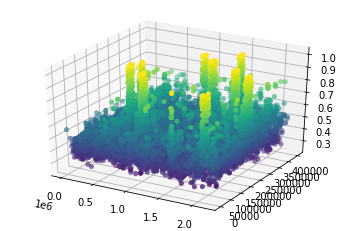

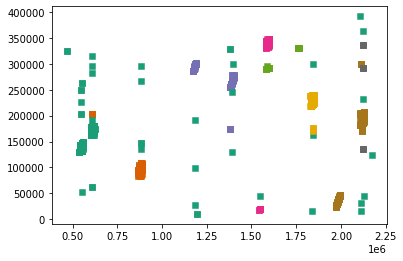

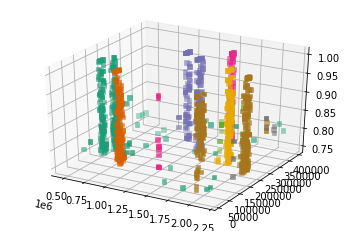

source_ref: source-document06275.txt this_segment: offset: 538256 length: 18731 source_segment: offset: 130227 length: 18704 similarity_value: 0.8549673557281494
source_ref: source-document06275.txt this_segment: offset: 603454 length: 19750 source_segment: offset: 161864 length: 18965 similarity_value: 0.8549673557281494
source_ref: source-document06275.txt this_segment: offset: 865587 length: 23962 source_segment: offset: 83215 length: 26033 similarity_value: 0.8549673557281494
source_ref: source-document06275.txt this_segment: offset: 1171969 length: 16203 source_segment: offset: 285619 length: 16005 similarity_value: 0.8549673557281494
source_ref: source-document06275.txt this_segment: offset: 1380832 length: 111 source_segment: offset: 173826 length: 120 similarity_value: 0.8549673557281494
source_ref: source-document06275.txt this_segment: offset: 1381497 length: 23616 source_segment: offset: 254425 length: 23650 similarity_value: 0.8549673557281494
source_ref: source-document062

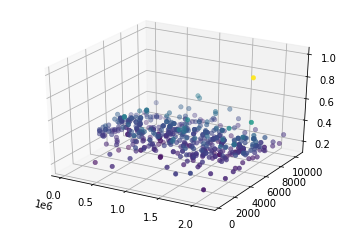

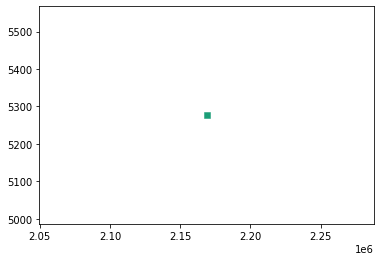

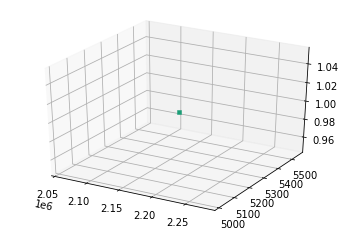

100.0%
Recall:  0.6838848707271423
Precision:  0.9999506147856763
Granularity:  1.025
F1:  0.8122540507191642
True positive:  32
False positive:  0
False negative:  9
Overall score:  0.7979532067614648


In [ ]:
metrics = ValidationMetrics()

print("LOADING")
count = 0.0
pred_result = Predictions()
features_list_dic = {}

for sus in sus_sample:
  pred_result += scan_for_plagiarism(sus, source_sample)

  count += 1.0
  print(str(count / len(sus_sample) * 100) + "%")
  features_list_dic[extract_path_and_doc_name(sus)[1] + ".txt"] = FeaturesList(sus[:-4] + ".xml")

metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

In [ ]:
sus_sample, source_sample = extract_sample(70)

print("suspicios sample: " + str(len(sus_sample)))
print("sources sample: " + str(len(source_sample)))

metrics = ValidationMetrics()

print("LOADING")
count = 0.0
pred_result = Predictions()
features_list_dic = {}

for sus in sus_sample:
  pred_result += scan_for_plagiarism(sus, source_sample)

  count += 1.0
  print(str(count / len(sus_sample) * 100) + "%")
  features_list_dic[extract_path_and_doc_name(sus)[1] + ".txt"] = FeaturesList(sus[:-4] + ".xml")

metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

suspicios sample: 70
sources sample: 129
LOADING
1.4285714285714286%
2.857142857142857%
4.285714285714286%
5.714285714285714%
7.142857142857142%
8.571428571428571%
10.0%
11.428571428571429%
12.857142857142856%
14.285714285714285%
15.714285714285714%
17.142857142857142%
18.571428571428573%
20.0%
21.428571428571427%
22.857142857142858%
24.285714285714285%
25.71428571428571%
27.142857142857142%
28.57142857142857%
30.0%
31.428571428571427%
32.857142857142854%
34.285714285714285%
35.714285714285715%
37.142857142857146%
38.57142857142858%
40.0%
41.42857142857143%
42.857142857142854%
44.285714285714285%
45.714285714285715%
47.14285714285714%
48.57142857142857%
50.0%
51.42857142857142%
52.85714285714286%
54.285714285714285%
55.714285714285715%
57.14285714285714%
58.57142857142858%
60.0%
61.42857142857143%
62.857142857142854%
64.28571428571429%
65.71428571428571%
67.14285714285714%
68.57142857142857%
70.0%
71.42857142857143%
72.85714285714285%
74.28571428571429%
75.71428571428571%
77.1428571428

In [ ]:
sus_sample, source_sample = extract_sample(100)

print("suspicios sample: " + str(len(sus_sample)))
print("sources sample: " + str(len(source_sample)))

metrics = ValidationMetrics()

print("LOADING")
count = 0.0
pred_result = Predictions()
features_list_dic = {}

for sus in sus_sample:
  pred_result += scan_for_plagiarism(sus, source_sample)

  count += 1.0
  print(str(count / len(sus_sample) * 100) + "%")
  features_list_dic[extract_path_and_doc_name(sus)[1] + ".txt"] = FeaturesList(sus[:-4] + ".xml")

metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

suspicios sample: 100
sources sample: 174
LOADING
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.000000000000001%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.000000000000002%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.000000000000004%
28.999999999999996%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.00000000000001%
56.00000000000001%
56.99999999999999%
57.99999999999999%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%
Recall:  0.5566333413714288
Precision:  0.9623053967600298
Granularity:  1.0090579710144927
F1:  0.7052967377436591
True positive:  357
False positive:  11
False negative:  193
Overall score:  0.7007285527985962


In [ ]:
f_encoplot = open("/content/drive/MyDrive/ColabNotebooks/ColabData/encoplotRes.txt", "r+")


suspicious_doc = None
suspicious_doc_path = ""
suspicious_doc_name = ""

source_doc = None
source_doc_path = ""
source_doc_name = ""

check_pending = False

metrics = ValidationMetrics()

pred_result = Predictions()
features_list_dic = {}

cur_line = f_encoplot.readline()

while cur_line != "":
  arg = cur_line.split(" ")

  if check_pending == True:
    check_pending = False

    suspicious_posible_offsets = []
    source_posible_offsets = []
    current_pred = Predictions()

    print("Computing embeddings")

    while cur_line[0] == "r":
      arg = cur_line.split(" ")
      suspicious_posible_offsets.append(int(arg[1]))
      source_posible_offsets.append(int(arg[2]))

      cur_line = str(f_encoplot.readline())

    suspicious_doc.split_segments(SEGMENTS_SIZE, SEGMENTS_SIZE / 4, suspicious_posible_offsets)
    suspicious_doc.compute_embeddings(MODEL_NAME)

    source_doc.split_segments(SEGMENTS_SIZE, SEGMENTS_SIZE / 4,  source_posible_offsets)
    source_doc.compute_embeddings(MODEL_NAME)

    similar_segments = get_most_similars(source_doc, suspicious_doc)
    current_pred.add_prediction(similar_segments, suspicious_doc.doc_name)

    pred_result += current_pred

    continue

  elif arg[0] == "fsus":
    index = arg[1][-10:-5]
    sus_doc_name =  SUSPICIOUS_DOCUMENT_PREFIX + index
    part_folder = str(check_part_folder(sus_doc_name))
    full_path = PATH_SUSPICIOUS + part_folder + "/" + sus_doc_name + ".txt"

    suspicious_doc_path, suspicious_doc_name = extract_path_and_doc_name(full_path)
    suspicious_doc = suspicious_doc = Document(suspicious_doc_path, suspicious_doc_name)

    features_list_dic[suspicious_doc_path + suspicious_doc_name + ".txt"] = FeaturesList(suspicious_doc_path + suspicious_doc_name + ".xml")

    print(full_path)

  elif arg[0] == "fsour":
    index = arg[1][-10:-5]
    source_doc_name =  SOURCE_DOCUMENT_PREFIX + index
    part_folder = str(check_part_folder(source_doc_name))
    full_path = PATH_SOURCE + part_folder + "/" + source_doc_name + ".txt"

    source_doc_path, source_doc_name = extract_path_and_doc_name(full_path)
    source_doc = Document(source_doc_path, source_doc_name)
    check_pending = True

    print(full_path)

  cur_line = str(f_encoplot.readline())

f_encoplot.close()

metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00001.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part1/source-document01409.txt
Computing embeddings



/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00002.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part1/source-document00229.txt
Computing embeddings
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part1/source-document00749.txt
Computing embeddings
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part1/source-document01390.txt
Computing embeddings
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part1/source-document01533.txt
Computing embeddings
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part1/source-document01894.txt
Computing embeddings
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/source-documents/part2/source-document02400.txt
Computing embeddings
/content/drive/MyD

KeyboardInterrupt: ignored

In [ ]:
f_encoplot = open("/content/drive/MyDrive/ColabNotebooks/ColabData/encoplotRes.txt", "r+")


suspicious_doc = None
suspicious_doc_path = ""
suspicious_doc_name = ""

source_doc = None
source_doc_path = ""
source_doc_name = ""

check_sources = False
check_sus = False

metrics = ValidationMetrics()

pred_result = Predictions()
features_list_dic = {}

candidates = []

cur_line = f_encoplot.readline()

try:
  while cur_line != "":
    arg = cur_line.split(" ")

    if check_sources == True and check_sus == True:
      check_sources = False
      check_sus = False

      for it in range(10):
        if len(candidates) > it:
          source_doc_name = candidates[it][0]
          suspicious_posible_offsets = candidates[it][1]
          source_posible_offsets = candidates[it][2]

          part_folder = str(check_part_folder(source_doc_name))
          full_path = PATH_SOURCE + part_folder + "/" + source_doc_name + ".txt"

          source_doc_path, source_doc_name = extract_path_and_doc_name(full_path)
          source_doc = Document(source_doc_path, source_doc_name)

          current_pred = Predictions()

          suspicious_doc.split_segments(SEGMENTS_SIZE, SEGMENTS_SIZE / 4, suspicious_posible_offsets)
          suspicious_doc.compute_embeddings(MODEL_NAME)

          source_doc.split_segments(SEGMENTS_SIZE, SEGMENTS_SIZE / 4,  source_posible_offsets)
          source_doc.compute_embeddings(MODEL_NAME)

          similar_segments = get_most_similars(source_doc, suspicious_doc)
          current_pred.add_prediction(similar_segments, suspicious_doc.doc_name)

          pred_result += current_pred
        
        else:
          continue

    elif arg[0] == "fsus":
      if check_sus == True and check_sources == False:
        current_pred.add_prediction([], suspicious_doc.doc_name)
        pred_result += current_pred

      check_sus = True

      index = arg[1][-10:-5]
      sus_doc_name =  SUSPICIOUS_DOCUMENT_PREFIX + index
      part_folder = str(check_part_folder(sus_doc_name))
      full_path = PATH_SUSPICIOUS + part_folder + "/" + sus_doc_name + ".txt"

      suspicious_doc_path, suspicious_doc_name = extract_path_and_doc_name(full_path)
      suspicious_doc = suspicious_doc = Document(suspicious_doc_path, suspicious_doc_name)

      features_list_dic[suspicious_doc_name + ".txt"] = FeaturesList(suspicious_doc_path + suspicious_doc_name + ".xml")

      print(full_path)
      cur_line = str(f_encoplot.readline())

    elif arg[0] == "fsour":
      candidates = []

      while arg[0] == "fsour":
        index = arg[1][-10:-5]
        source_doc_name =  SOURCE_DOCUMENT_PREFIX + index

        suspicious_posible_offsets = []
        source_posible_offsets = []

        cur_line = str(f_encoplot.readline())

        while cur_line[0] == "r":
          arg = cur_line.split(" ")
          suspicious_posible_offsets.append(int(arg[1]))
          source_posible_offsets.append(int(arg[2]))

          cur_line = str(f_encoplot.readline())

        candidates.append([source_doc_name, suspicious_posible_offsets, source_posible_offsets])
        arg = cur_line.split(" ")

      candidates.sort(key=lambda x: len(x[1]), reverse=True)
      check_sources = True
except:
  pass

if check_sus == True and check_sources == False:
  check_sus = False
  current_pred.add_prediction([], suspicious_doc.doc_name)
  pred_result += current_pred

f_encoplot.close()

metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00001.txt



/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00002.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00003.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00004.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00005.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00006.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00007.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00008.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/pa

In [ ]:
metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

KeyError: ignored

In [ ]:
for it in features_list_dic:
  print(it)

/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00035.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00036.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00037.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00038.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00039.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00040.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/part1/suspicious-document00041.txt
/content/drive/MyDrive/ColabNotebooks/ColabData/external-analysis-corpus/suspicious-documents/par

In [ ]:
metrics.add_to_evaluate(pred_result, features_list_dic)

print("Overall score: ", metrics.get_overall_score())

KeyError: ignored